# Transfer learning with TensorFlow Hub

This document is based on the code found at https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub



---


**Please reset all runtimes and use "restart and run all..." to run this Colab, there might be some issues otherwise**

## Setup

In [0]:
from google.colab import files
import pathlib

We are using TensorFlow version 2, as it is now available as a stable version and we also experienced some problems when using TensorFlow 1

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import numpy as np
import PIL.Image as Image

%tensorflow_version 2.x

!pip -q install tensorflow
import tensorflow as tf
print("TensorFlow version is " + tf.__version__)

TensorFlow 2.x selected.
TensorFlow version is 2.0.0


In [0]:
!pip -q install -U tensorflow-hub
import tensorflow_hub as hub

from tensorflow.keras import layers

## An ImageNet classifier

### Download the classifier

We are using a pretrained MobileNet v2 model for our model, as it has good performance on mobile devices.

In [0]:
classifier_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

In [0]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

The MobileNet model we are using is pretrained on ImageNet

In [6]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


## Simple transfer learning

### Dataset

 For this example you will use the TensorFlow flowers dataset:

In [7]:
data_root = tf.keras.utils.get_file(
  'product_photos','https://firebasestorage.googleapis.com/v0/b/mcateam6-bacc0.appspot.com/o/product_photos.tgz?alt=media&token=5d634f4e-b902-440a-a165-c6548c03a850',
   untar=True)

262144/258178 [==============================] - 0s 0us/step


Creates twenty copies of each picture

In [0]:
import os
import shutil

for r, d, f in os.walk(str(data_root)):
  for file in f:
    i = 0
    while i < 20:
      file = file.split('.')[0]
      shutil.copy(r+'/'+file+".png",r+'/'+file+str(i)+".png")
      i += 1

Verify that the copies are created successfully

In [9]:
%ls {str(data_root)+"/Pejlfab9Hpqhjevwj9Zt"}

ls: cannot access '/root/.keras/datasets/product_photos/cappuccino': No such file or directory


We are using `tf.keras.preprocessing.image.ImageDataGenerator` to transform the image to increase the training efficiency. Due to the requiring the use to take photos, we only have a limit input dataset. To improve accuracy, we apply several transformations to the input images. See https://keras.io/preprocessing/image/ for a detailed description on all transformations.

In [10]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
                                                                  rotation_range=90,
                                                                  width_shift_range=0.3,
                                                                  height_shift_range=0.3,
                                                                  brightness_range=[0.5, 1.5],
                                                                  shear_range=0.01,
                                                                  zoom_range=[0.9, 1.25],
                                                                  horizontal_flip=True,
                                                                  vertical_flip=True
                                                                  )
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE, batch_size=100)

Found 147 images belonging to 6 classes.


In [11]:
%ls {str(data_root)}

5FOOWmvh9IqDmF7hgkQW/  NDNsobfegSx16CCtRTc9/  QCTSig5E2CPyJDTe2gFR/
HQ9Ynt7SR88h8rX4PusQ/  PejLfAB9HpqhJevwJ9Zt/  ZyIC9zsr1CXmun5hbsrj/


Download the entire working directory as a .zip file (for debugging purposes)

In [0]:
# !zip -q -r /content/file.zip {str(data_root)}
# files.download("/content/file.zip")

The resulting object is an iterator that returns `image_batch, label_batch` pairs.

In [13]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

data_root = pathlib.Path(data_root)
CLASS_NAMES = np.array([item.name for item in data_root.glob('*') if item.name != "LICENSE.txt"])

Image batch shape:  (100, 224, 224, 3)
Label batch shape:  (100, 6)


To enhance the validation procedure, we also create a new random image generation dataset

In [14]:
validation_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
                                                                  rotation_range=90,
                                                                  width_shift_range=0.3,
                                                                  height_shift_range=0.3,
                                                                  brightness_range=[0.5, 1.5],
                                                                  shear_range=0.01,
                                                                  zoom_range=[0.9, 1.25],
                                                                  horizontal_flip=True,
                                                                  vertical_flip=True
                                                                  )
validation_data = validation_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE, batch_size=100)

Found 147 images belonging to 6 classes.


### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any [Tensorflow 2 compatible image feature vector URL](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) from tfhub.dev will work here.

In [0]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_075_224/feature_vector/4"

Create the feature extractor.

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

It returns a 1280-length vector for each image:

In [17]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(100, 1280)


Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [0]:
feature_extractor_layer.trainable = False

### Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [19]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              1382064   
_________________________________________________________________
dense (Dense)                (None, 6)                 7686      
Total params: 1,389,750
Trainable params: 7,686
Non-trainable params: 1,382,064
_________________________________________________________________


In [0]:
predictions = model(image_batch)

In [21]:
predictions.shape

TensorShape([100, 6])

### Train the model

Use compile to configure the training process:

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

Now use the `.fit` method to train the model.

To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [24]:
# steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)
steps_per_epoch = 5

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=20,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback], verbose=1,
                              validation_data=validation_data,
                              shuffle=True,
                              validation_steps=10)

Epoch 1/20
5/5 [==============================] - 24s 5s/step - loss: 2.0273 - acc: 0.4500 - val_loss: 1.2236 - val_acc: 0.5673
Epoch 2/20
5/5 [==============================] - 18s 4s/step - loss: 0.9118 - acc: 0.8511 - val_loss: 0.5328 - val_acc: 0.9252
Epoch 3/20
5/5 [==============================] - 17s 3s/step - loss: 0.3874 - acc: 1.0000 - val_loss: 0.2361 - val_acc: 0.9905
Epoch 4/20
5/5 [==============================] - 18s 4s/step - loss: 0.1742 - acc: 1.0000 - val_loss: 0.1291 - val_acc: 0.9932
Epoch 5/20
5/5 [==============================] - 17s 3s/step - loss: 0.0982 - acc: 1.0000 - val_loss: 0.0767 - val_acc: 0.9986
Epoch 6/20
5/5 [==============================] - 18s 4s/step - loss: 0.0437 - acc: 1.0000 - val_loss: 0.0414 - val_acc: 1.0000
Epoch 8/20
5/5 [==============================] - 18s 4s/step - loss: 0.0365 - acc: 1.0000 - val_loss: 0.0340 - val_acc: 0.9986
Epoch 9/20
5/5 [==============================] - 17s 3s/step - loss: 0.0289 - acc: 1.0000 - val_loss: 0

Now after, even just a few training iterations, we can already see that the model is making progress on the task.

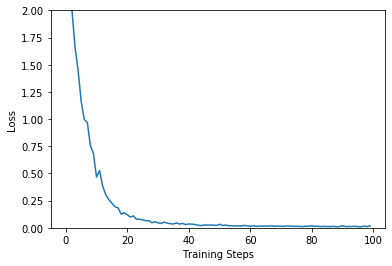

In [25]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

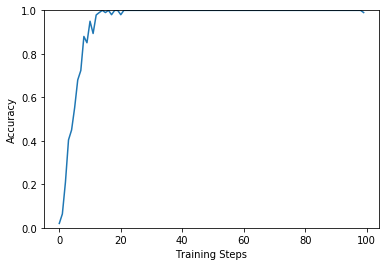

In [26]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Check the predictions

To redo the plot from before, first get the ordered list of class names:

In [27]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['5Foowmvh9Iqdmf7Hgkqw', 'Hq9Ynt7Sr88H8Rx4Pusq',
       'Ndnsobfegsx16Cctrtc9', 'Pejlfab9Hpqhjevwj9Zt',
       'Qctsig5E2Cpyjdte2Gfr', 'Zyic9Zsr1Cxmun5Hbsrj'], dtype='<U20')

Run the image batch through the model and convert the indices to class names.

In [0]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

Plot the result

In [0]:
label_id = np.argmax(label_batch, axis=-1)

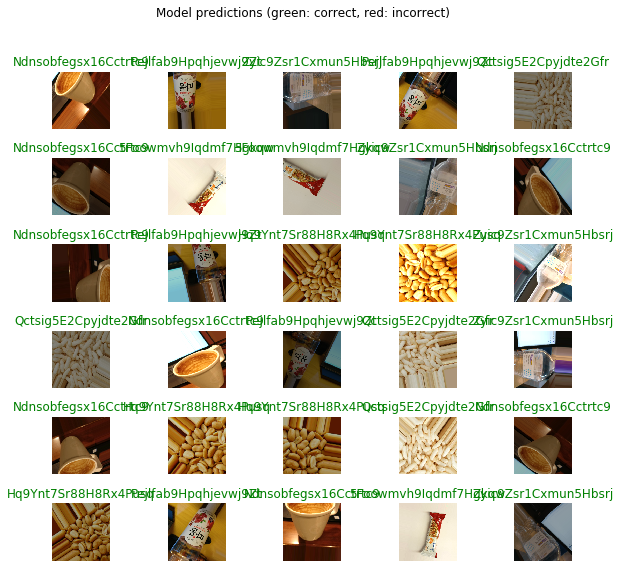

In [30]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Export

Now that we've trained the model, we export it as a saved model:

In [31]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')
# tf.keras.models.save_model(model, export_path, save_format='tf')

export_path

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /tmp/saved_models/1575895283/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1575895283/assets


'/tmp/saved_models/1575895283'

Convert model to Tensorflow Lite in order to use it on mobile devices

In [0]:
model = tf.keras.models.load_model(export_path)

In [0]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Download .tflite file

In [0]:
open("products.tflite", "wb").write(tflite_model)
files.download("products.tflite")

Download labels.txt file (make sure that you accept the multiple downloads permission). TensorFlow removes most of the upper-case characters in the labels, so please compare the text file to the labels in the database.

In [0]:
with open("labelmap.txt", 'w') as f:
  print("\n".join(class_names.tolist()), file=f)
files.download("labelmap.txt")